In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr


sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.1.0'

In [2]:
plt.rc('text', usetex=True)


In [3]:
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0        
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus - s_plus)**2

### MOMENTUM DISTRIBUTION EXAMPLES

# Long thin box limit: assuming that Lz > Lx,Ly, 
# so the lowest excited states are nz=2, nz=3, with nx=ny=1. 

def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    (Lx, Ly, Lz) = Lvec
    (qx, qy, qz) = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

def DeltaE_nz(nz, Lz):
    # for nx=ny=1 final states, in units of [q**2]/mElec
    return 0.5*math.pi**2 / mElec * (nz**2 - 1)/Lz**2

def fs2_m1(qDMsph):
    # Taking Lz = 10*a0 for all examples, with DeltaE = 4.0285 eV for nz=2.
    Lx = 4/qBohr
    Ly = 4/qBohr
    Lz = 10/qBohr
    Lvec = (Lx, Ly, Lz)
    (q, theta, phi) = qDMsph
    q_xyz = (q * np.sin(theta) * np.cos(phi), 
              q * np.sin(theta) * np.sin(phi), 
              q * np.cos(theta))
    return fs2_nz(Lvec, 2, q_xyz)

def fs2_m2(qDMsph):
    # Taking Lz = 10*a0 for all examples, with DeltaE = 4.0285 eV for nz=2.
    Lx = 8/qBohr
    Ly = 8/qBohr
    Lz = 10/qBohr
    Lvec = (Lx, Ly, Lz)
    (q, theta, phi) = qDMsph
    q_xyz = (q * np.sin(theta) * np.cos(phi), 
              q * np.sin(theta) * np.sin(phi), 
              q * np.cos(theta))
    return fs2_nz(Lvec, 2, q_xyz)

def fs2_m3(qDMsph):
    # Taking Lz = 10*a0 for all examples, with DeltaE = 4.0285 eV for nz=2.
    Lx = 4/qBohr
    Ly = 7/qBohr
    Lz = 10/qBohr
    Lvec = (Lx, Ly, Lz)
    (q, theta, phi) = qDMsph
    q_xyz = (q * np.sin(theta) * np.cos(phi), 
              q * np.sin(theta) * np.sin(phi), 
              q * np.cos(theta))
    return fs2_nz(Lvec, 2, q_xyz)

def fs2_model4_cart(q_xyz):
    return fs2_nz((4/qBohr, 7/qBohr, 10/qBohr), 2, q_xyz)


## Read coeffs from data

In [4]:
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

def fs2_model4(qSph):
    (q, theta, phi) = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    return fs2_nz((4/qBohr, 7/qBohr, 10/qBohr), 2, (qx,qy,qz))
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2


bdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)
vegas_params = dict(neval=3e4, nitn_init=5, 
                    neval_init=1e3, nitn=10, verbose=True, 
                    weight_by_vol=True, neval_min=1e3)

# # Read Fnlm from saved csv file...
wave_csv = vsdm.ProjectFnlm(bdict, fs2_model4, vegas_params, 
                            nlmlist=None, f_type='fs2', use_gvar=False)
wave_csv.importFnlm_csv('demo/fs2_box_4_7_10.csv')
wave_csv.basis

{'u0': 37289.47137978341,
 'type': 'wavelet',
 'uMax': 37289.47137978341,
 'neval': 30000.0,
 'nitn_init': 5,
 'neval_init': 1000.0,
 'nitn': 10,
 'verbose': True,
 'weight_by_vol': True,
 'neval_min': 1000.0,
 'is_gaussian': False}

## Energy/Power convergence

In [78]:
"""Direct calculation of norm"""
t0 = time.time()
vegas_energy = dict(neval=1e7, nitn=10, verbose=True,  
                    nitn_init=5, neval_init=1e4)
totalEnergy = wave_csv.getDistEnergy(vegas_energy)
tEnergyInt = time.time() - t0


itn   integral          wgt average       chi2/dof        Q
-----------------------------------------------------------
  1   0.0000249137(63)  0.0000249137(63)      0.00     1.00
  2   0.0000249148(25)  0.0000249147(23)      0.03     0.87
  3   0.0000249098(19)  0.0000249118(15)      1.28     0.28
  4   0.0000249106(17)  0.0000249113(11)      0.95     0.42
  5   0.0000249118(14)  0.00002491148(88)     0.74     0.57
  6   0.0000249104(13)  0.00002491116(73)     0.68     0.64
  7   0.0000249125(12)  0.00002491151(63)     0.71     0.64
  8   0.0000249112(11)  0.00002491144(54)     0.61     0.74
  9   0.0000249118(10)  0.00002491152(48)     0.55     0.82
 10   0.00002491153(96) 0.00002491152(43)     0.49     0.88

energy: 0.0000996461(17)


In [79]:
print('energy integration time: {}'.format(tEnergyInt))

energy integration time: 5606.280382871628


In [80]:
energy = wave_csv.f2nlm_energy()
# f2nlm_energy
# print(energy)
print('energy from integration: {} * qBohr**3'.format(totalEnergy/qBohr**3))
print('energy fraction from fnlm**2: {}'.format(energy/totalEnergy))
energy_for_norm = max(energy.mean, totalEnergy.mean)

energy from integration: 1.921771(33)e-15 * qBohr**3
energy fraction from fnlm**2: 0.99786(94)


In [8]:
sume = 0.
conv = []
primary_keys_1e6 = []
for key,value in wave_csv.f_nlm.items():
    power = value**2/energy_for_norm
    if power > 5e-7:
        primary_keys_1e6 += [key]
        sume += power
        conv += [sume.mean]
        print('{}\t{:.6G}\t{}'.format(key, power.mean, sume.mean))
    


(0, 0, 0)	0.00780785	0.007807849587026819
(0, 2, 0)	4.64953E-05	0.007854344935701522
(0, 2, 2)	0.000699615	0.008553960393817948
(0, 4, 0)	0.000324642	0.008878602555173344
(0, 4, 2)	3.69998E-05	0.008915602309399567
(0, 4, 4)	0.00114889	0.010064487618816047
(0, 6, 0)	0.000564795	0.010629282808269393
(0, 6, 2)	5.19719E-06	0.010634479998864228
(0, 6, 4)	0.000115862	0.010750341940014075
(0, 6, 6)	2.94414E-05	0.010779783342883136
(0, 8, 0)	3.32645E-05	0.010813047810013523
(0, 8, 2)	0.000257844	0.011070892097849762
(0, 8, 4)	2.95693E-05	0.011100461372949217
(0, 8, 8)	0.000271126	0.011371587494182772
(0, 10, 0)	7.66783E-05	0.011448265772703302
(0, 10, 2)	3.42543E-05	0.011482520092246762
(0, 10, 4)	2.43631E-06	0.011484956402484961
(0, 10, 6)	4.74145E-06	0.011489697849731601
(0, 10, 8)	4.01051E-05	0.011529802905336525
(0, 10, 10)	0.000211494	0.01174129696941772
(0, 12, 0)	3.98721E-06	0.011745284180712917
(0, 12, 2)	0.000101334	0.01184661778897325
(0, 12, 4)	6.10672E-07	0.01184722846132677
(0, 12

(41, 22, 2)	7.85797E-05	0.9661671874865607
(41, 22, 4)	2.22409E-06	0.9661694115751328
(41, 22, 6)	4.56764E-06	0.9661739792139667
(41, 22, 8)	1.01775E-06	0.9661749969618072
(41, 22, 10)	1.21106E-05	0.966187107527107
(41, 22, 14)	5.26074E-07	0.966187633601211
(41, 22, 20)	7.50551E-07	0.9661883841521776
(41, 24, 2)	2.40654E-06	0.9661907906893855
(41, 24, 8)	5.92799E-07	0.9661913834881248
(41, 24, 10)	2.03434E-05	0.9662117268849606
(41, 24, 12)	5.48414E-05	0.9662665682904935
(41, 24, 14)	1.47852E-05	0.9662813534609557
(41, 24, 16)	1.16068E-06	0.9662825141376491
(41, 24, 22)	9.47905E-07	0.966283462043095
(42, 0, 0)	3.41304E-05	0.9663175924528153
(42, 2, 0)	2.15573E-06	0.966319748186039
(42, 2, 2)	1.60716E-05	0.9663358197692439
(42, 4, 0)	1.80151E-06	0.9663376212784489
(42, 4, 2)	8.48498E-06	0.9663461062574219
(42, 4, 4)	1.54743E-06	0.9663476536880466
(42, 6, 0)	3.63662E-05	0.9663840198939472
(42, 6, 2)	4.43775E-06	0.9663884576416224
(42, 6, 4)	5.39698E-07	0.9663889973400074
(42, 6, 6)	1.112

(84, 26, 12)	1.36087E-06	0.9899491659313115
(0, 26, 14)	1.18035E-05	0.9899609693900716
(1, 26, 14)	7.40253E-05	0.9900349947348078
(2, 26, 14)	1.84478E-05	0.9900534425076709
(4, 26, 14)	4.53424E-06	0.9900579767447667
(5, 26, 14)	0.000198031	0.9902560082179744
(9, 26, 14)	3.94582E-05	0.9902954663696218
(10, 26, 14)	0.000373949	0.9906694151215668
(11, 26, 14)	2.55966E-06	0.9906719747823932
(19, 26, 14)	1.66938E-05	0.9906886685446576
(20, 26, 14)	3.55249E-05	0.9907241933967036
(38, 26, 14)	5.01587E-06	0.9907292092695065
(39, 26, 14)	4.20426E-06	0.9907334135317898
(41, 26, 14)	2.68977E-05	0.9907603112267941
(42, 26, 14)	8.04932E-07	0.9907611161587653
(45, 26, 14)	5.75684E-07	0.9907616918425168
(65, 26, 14)	1.00081E-06	0.990762692654372
(66, 26, 14)	7.74143E-07	0.9907634667970576
(67, 26, 14)	1.5152E-05	0.9907786188325007
(74, 26, 14)	1.476E-06	0.9907800948297767
(76, 26, 14)	2.57009E-06	0.990782664920434
(77, 26, 14)	5.02272E-07	0.9907831671926697
(79, 26, 14)	1.64135E-06	0.9907848085389216

(77, 34, 24)	1.09328E-06	0.9958612849663039
(79, 34, 24)	9.7243E-07	0.9958622573961502
(81, 34, 24)	1.10098E-06	0.9958633583739501
(1, 34, 26)	1.00649E-06	0.9958643648620822
(5, 34, 26)	9.15296E-07	0.9958652801584688
(9, 34, 26)	9.076E-07	0.9958661877586041
(11, 34, 26)	1.09232E-06	0.9958672800773309
(17, 34, 26)	1.35308E-06	0.9958686331615855
(18, 34, 26)	1.20467E-06	0.9958698378361241
(34, 34, 26)	2.01658E-06	0.9958718544186431
(38, 34, 26)	6.71354E-06	0.9958785679590942
(39, 34, 26)	6.81042E-07	0.9958792490011669
(41, 34, 26)	5.2364E-07	0.9958797726411045
(72, 34, 26)	5.36673E-07	0.9958803093139869
(73, 34, 26)	5.72772E-07	0.9958808820862712
(74, 34, 26)	1.1963E-06	0.995882078383605
(75, 34, 26)	5.54198E-07	0.9958826325813653
(79, 34, 26)	2.6143E-06	0.9958852468810604
(80, 34, 26)	6.02835E-07	0.995885849715746
(81, 34, 26)	5.08241E-07	0.9958863579571956
(83, 34, 26)	5.34114E-07	0.9958868920707592
(0, 34, 28)	6.56603E-07	0.9958875486734786
(1, 34, 28)	5.78716E-07	0.9958881273894811
(

In [15]:
# Sorted
sume = 0.
conv = []
for key,value in wave_csv.getNLMpower().items():
    power = value/energy_for_norm
    sume += power
    conv += [sume.mean]
    if power > 1e-5:
        print('{}  \t{}  \t{}'.format(key, power, sume))
    


(2, 0, 0)  	0.12412(28)  	0.12412(28)
(4, 2, 0)  	0.07385(20)  	0.19798(34)
(1, 0, 0)  	0.041958(77)  	0.23994(35)
(4, 0, 0)  	0.04115(13)  	0.28109(38)
(4, 4, 0)  	0.03372(15)  	0.31480(41)
(17, 4, 0)  	0.02780(14)  	0.34260(43)
(9, 2, 2)  	0.02529(13)  	0.36789(45)
(8, 0, 0)  	0.021122(54)  	0.38901(45)
(17, 2, 0)  	0.017026(96)  	0.40604(46)
(2, 2, 0)  	0.016217(88)  	0.42225(47)
(8, 4, 0)  	0.016196(73)  	0.43845(48)
(2, 4, 4)  	0.015881(82)  	0.45433(48)
(9, 2, 0)  	0.01438(11)  	0.46871(50)
(4, 6, 0)  	0.01413(10)  	0.48283(51)
(4, 4, 2)  	0.013821(80)  	0.49665(51)
(18, 4, 0)  	0.01207(14)  	0.50873(53)
(36, 4, 0)  	0.01108(16)  	0.51980(56)
(2, 6, 0)  	0.010811(93)  	0.53061(56)
(9, 12, 0)  	0.00963(15)  	0.54025(58)
(9, 0, 0)  	0.00925(10)  	0.54950(59)
(2, 8, 2)  	0.009118(90)  	0.55861(60)
(2, 6, 4)  	0.008894(67)  	0.56751(60)
(9, 6, 2)  	0.00881(12)  	0.57632(61)
(18, 2, 0)  	0.00814(10)  	0.58446(62)
(0, 0, 0)  	0.007808(11)  	0.59226(62)
(9, 4, 2)  	0.00751(11)  	0.59977

(10, 26, 16)  	0.0000257(35)  	0.98010(91)
(11, 4, 2)  	0.00002560(76)  	0.98013(91)
(39, 2, 2)  	0.0000256(59)  	0.98015(91)
(74, 10, 2)  	0.0000254(84)  	0.98018(91)
(0, 14, 10)  	0.00002534(55)  	0.98020(91)
(21, 18, 18)  	0.0000253(11)  	0.98023(91)
(1, 20, 4)  	0.0000253(23)  	0.98025(91)
(6, 4, 4)  	0.00002505(24)  	0.98028(91)
(40, 20, 8)  	0.0000250(66)  	0.98030(91)
(35, 10, 4)  	0.0000250(98)  	0.98033(91)
(10, 22, 8)  	0.0000249(37)  	0.98035(91)
(38, 18, 2)  	0.0000249(84)  	0.98038(91)
(20, 20, 14)  	0.0000249(50)  	0.98040(91)
(11, 32, 4)  	0.0000248(11)  	0.98043(91)
(41, 16, 14)  	0.0000248(41)  	0.98045(91)
(37, 8, 0)  	0.0000247(74)  	0.98048(91)
(81, 2, 2)  	0.0000247(43)  	0.98050(91)
(0, 24, 12)  	0.00002472(62)  	0.98053(91)
(1, 34, 4)  	0.0000247(30)  	0.98055(91)
(42, 16, 14)  	0.0000246(20)  	0.98058(91)
(21, 20, 0)  	0.0000246(21)  	0.98060(91)
(1, 20, 14)  	0.0000246(23)  	0.98063(91)
(4, 12, 6)  	0.0000245(50)  	0.98065(91)
(80, 12, 0)  	0.0000245(60)  	0.98

(19, 6, 0)  	0.0000149(43)  	0.98461(92)
(41, 24, 14)  	0.0000148(29)  	0.98463(92)
(79, 6, 0)  	0.0000148(50)  	0.98464(92)
(11, 30, 4)  	0.00001476(84)  	0.98466(92)
(37, 18, 8)  	0.0000147(73)  	0.98467(92)
(18, 16, 10)  	0.0000147(72)  	0.98469(92)
(75, 12, 4)  	0.0000146(55)  	0.98470(92)
(81, 12, 0)  	0.0000145(36)  	0.98471(92)
(0, 20, 8)  	0.00001454(49)  	0.98473(92)
(1, 26, 26)  	0.0000145(12)  	0.98474(92)
(76, 8, 6)  	0.0000145(56)  	0.98476(92)
(36, 16, 6)  	0.000014(11)  	0.98477(92)
(40, 22, 8)  	0.0000144(51)  	0.98479(92)
(20, 26, 8)  	0.0000144(38)  	0.98480(92)
(1, 30, 20)  	0.0000144(19)  	0.98482(92)
(44, 12, 0)  	0.0000144(12)  	0.98483(92)
(10, 30, 10)  	0.0000144(30)  	0.98484(92)
(0, 14, 2)  	0.00001431(54)  	0.98486(92)
(21, 18, 4)  	0.0000143(13)  	0.98487(92)
(80, 14, 8)  	0.0000142(41)  	0.98489(92)
(21, 14, 0)  	0.0000142(13)  	0.98490(92)
(37, 16, 8)  	0.0000142(69)  	0.98492(92)
(10, 22, 16)  	0.0000142(26)  	0.98493(92)
(8, 6, 6)  	0.0000141(16)  	0.984

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


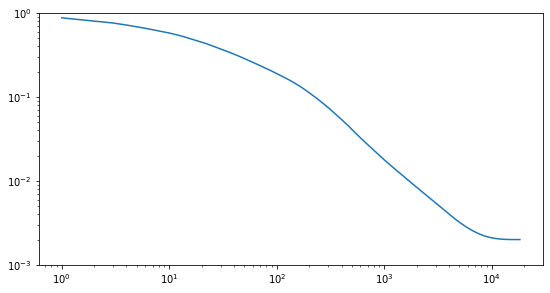

In [17]:
unisize = 3.5
fig = plt.figure(figsize=[2*unisize,unisize])
ax = fig.add_axes([0,0,1,1], xscale='log', yscale='log')
ax.plot([i+1 for i in range(len(conv))], 1-np.array(conv))
ax.set_ylim([1e-3, 1])
fig.show()

### Angular power 

In [19]:
powerLM = wave_csv.getLMpower()
sortlm = sorted(powerLM.items(), key=lambda z: z[1], reverse=True)

powerLM = {}
sum_lm = 0.
conv_lm = []
for entry in sortlm:
    key, power = entry
    powerLM[key] = power
    power /= energy_for_norm
    sum_lm += power
    conv_lm += [sum_lm.mean]
    print('{}  \t{:.6G}  \t{}'.format(key, power.mean, sum_lm))


(0, 0)  	0.274273  	0.27427(36)
(2, 0)  	0.152418  	0.42669(49)
(4, 0)  	0.113706  	0.54040(58)
(2, 2)  	0.0535341  	0.59393(61)
(6, 0)  	0.0476293  	0.64156(64)
(4, 2)  	0.0400544  	0.68162(68)
(6, 2)  	0.0281612  	0.70978(71)
(4, 4)  	0.0234593  	0.73324(71)
(8, 2)  	0.0212333  	0.75447(73)
(12, 0)  	0.0146629  	0.76913(75)
(8, 0)  	0.0143885  	0.78352(77)
(6, 4)  	0.014299  	0.79782(77)
(10, 2)  	0.0109825  	0.80880(79)
(10, 10)  	0.0107894  	0.81959(79)
(12, 2)  	0.0100495  	0.82964(80)
(12, 12)  	0.00964856  	0.83929(80)
(12, 10)  	0.00908848  	0.84838(81)
(14, 12)  	0.00810881  	0.85649(81)
(14, 0)  	0.00653113  	0.86302(82)
(8, 8)  	0.00636112  	0.86938(82)
(18, 0)  	0.00622747  	0.87561(83)
(18, 2)  	0.00590033  	0.88151(84)
(20, 0)  	0.0058567  	0.88736(84)
(16, 2)  	0.00563933  	0.89300(85)
(10, 0)  	0.00532015  	0.89832(85)
(16, 0)  	0.00521299  	0.90354(86)
(10, 8)  	0.00506161  	0.90860(86)
(8, 4)  	0.00488162  	0.91348(87)
(12, 4)  	0.00475282  	0.91823(87)
(6, 6)  	0.004

In [45]:
powerL = wave_csv.getLpower()
sum_l = 0.
conv_l = []
p_l = []
for key,power in powerL.items():
    power /= energy_for_norm
    sum_l += power
    p_l += [[key, power.mean]]
    conv_l += [sum_l.mean]
    print('{}  \t{:.6G}  \t{}'.format(key, power.mean, sum_l))

p_l = np.array(p_l)

0  	0.274273  	0.27427(36)
2  	0.205952  	0.48023(51)
4  	0.17722  	0.65745(66)
6  	0.0942272  	0.75167(72)
8  	0.0499461  	0.80162(76)
12  	0.0496867  	0.85131(81)
10  	0.0369849  	0.88829(84)
14  	0.0265189  	0.91481(86)
16  	0.0204275  	0.93524(88)
18  	0.0197772  	0.95501(90)
20  	0.0168222  	0.97184(91)
22  	0.0112751  	0.98311(92)
24  	0.00570224  	0.98881(92)
26  	0.0028419  	0.99166(93)
28  	0.00166577  	0.99332(93)
30  	0.00122351  	0.99454(93)
32  	0.00119059  	0.99574(93)
34  	0.0011602  	0.99690(94)
36  	0.0010973  	0.99799(94)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


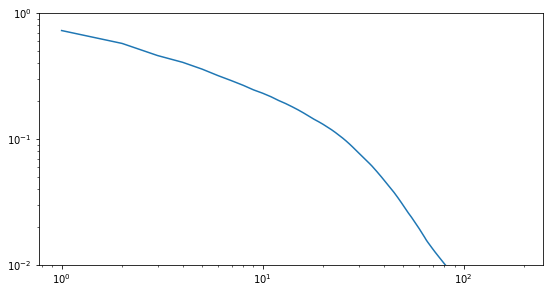

In [21]:
unisize = 3.5
fig = plt.figure(figsize=[2*unisize,unisize])
ax = fig.add_axes([0,0,1,1], xscale='log', yscale='log')
ax.plot([i+1 for i in range(len(conv_lm))], 1-np.array(conv_lm))
ax.set_ylim([1e-2, 1])
fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


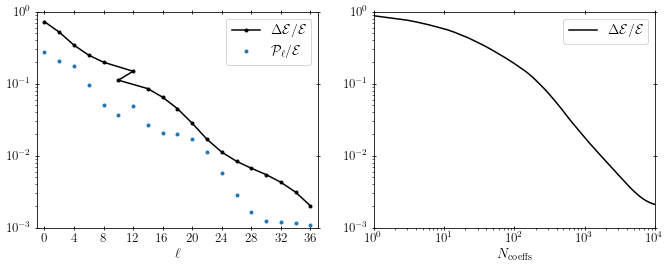

In [77]:
unisize = 3
fig = plt.figure(figsize=[1.3*unisize,unisize])
labels = 13
largelabels = 14
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
ax.plot([l for l in powerL.keys()], 1-np.array(conv_l), 
        marker='.', color='black', label=r'$\Delta\mathcal{E} / \mathcal{E}$')
ax.plot(p_l[:,0],p_l[:,1], 
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$')
ax.set_xlim([-1, 37])
ax.set_xticks([4*j for j in range(10)])
ax.set_ylim([1e-3, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
# ax.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)

ax2 = fig.add_axes([1.2,0,1,1], xscale='log', yscale='log')
ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         color='black', label=r'$\Delta\mathcal{E} / \mathcal{E}$')
ax2.set_xlim([1, 1e4])
ax2.set_ylim([1e-3, 1])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
# ax2.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='upper right', fontsize=largelabels)

fig.show()

In [99]:
"""Power in (lm)(n)"""
sortlm[0:9]

[((0, 0), 0.000027327(36)),
 ((2, 0), 0.000015186(32)),
 ((4, 0), 0.000011329(32)),
 ((2, 2), 5.334(17)e-06),
 ((6, 0), 4.745(21)e-06),
 ((4, 2), 3.991(23)e-06),
 ((6, 2), 2.806(19)e-06),
 ((4, 4), 2.3373(92)e-06),
 ((8, 2), 2.116(17)e-06)]

In [150]:
p_nlm = wave_csv.getNLMpower(lMax=12)
p_lm_n = {}
sump_lm_n = {}
for lmP in sortlm[0:9]:
    (lm,P) = lmP
    plm = P.mean
    p_lm_n[lm] = [p_nlm[(n, lm[0], lm[1])].mean/plm for n in range(96)]
    sump = 0.0
    sump_lm_n[lm] = np.zeros(96)
    for n in range(96):
        sump += p_lm_n[lm][n]
        sump_lm_n[lm][n] = sump


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


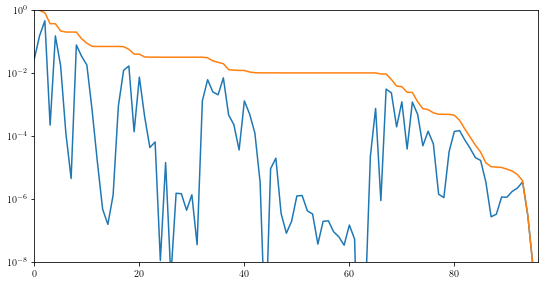

In [95]:
lbl = (0,0) 

unisize = 3.5
fig = plt.figure(figsize=[2*unisize,unisize])
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
ax.plot([n for n in range(len(eg))], p_lm_n[lbl], 
        [n+1 for n in range(len(eg))], 1-sump_lm_n[lbl])
ax.set_xlim([0, 96])
ax.set_ylim([1e-8, 1])
fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


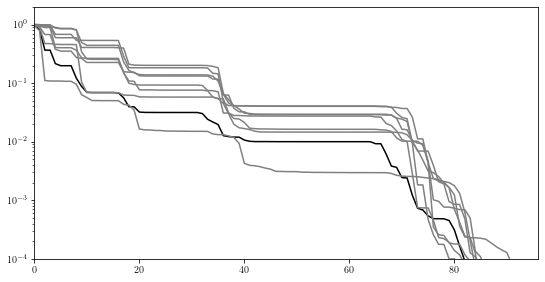

In [107]:
unisize = 3.5
fig = plt.figure(figsize=[2*unisize,unisize])
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
for lbl in p_lm_n.keys():
    if lbl == (0,0):
        ax.plot([n for n in range(len(eg))], 1-sump_lm_n[lbl], color='black')
    else:
        ax.plot([n for n in range(len(eg))], 1-sump_lm_n[lbl], color='gray')
ax.set_xlim([0, 96])
ax.set_ylim([1e-4, 2])
fig.show()

In [153]:
for lbl in sump_lm_n.keys():
    print(lbl, sump_lm_n[lbl][2])

(0, 0) 0.6340030016028279
(2, 0) 0.1103814442187841
(4, 0) 0.021167817573679366
(2, 2) 0.09102051255535229
(6, 0) 0.3234854527613274
(4, 2) 0.0562732493984066
(6, 2) 0.009405771113286644
(4, 4) 0.889259514352254
(8, 2) 0.5262224413087124


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


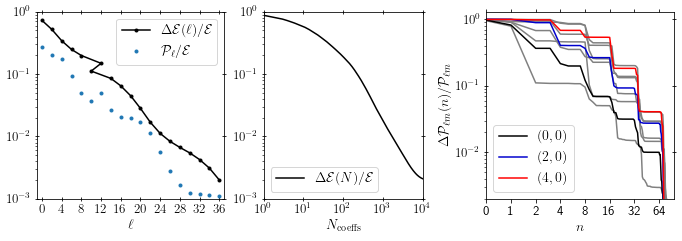

In [157]:
unisize = 2.6
fig = plt.figure(figsize=[1.*unisize,unisize])
labels = 13
largelabels = 14
nsize = 96
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
ax.plot([l for l in powerL.keys()], 1-np.array(conv_l), 
        marker='.', color='black', label=r'$\Delta\mathcal{E}(\ell) / \mathcal{E}$')
ax.plot(p_l[:,0],p_l[:,1], 
        marker='.', linestyle='None', label=r'$\mathcal{P}_\ell / \mathcal{E}$')
ax.set_xlim([-1, 37])
ax.set_xticks([4*j for j in range(10)])
ax.set_ylim([1e-3, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)

ax2 = fig.add_axes([1.21,0,0.85,1], xscale='log', yscale='log')
ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         color='black', label=r'$\Delta\mathcal{E}(N) / \mathcal{E}$')
ax2.set_xlim([1, 1e4])
ax2.set_ylim([1e-3, 1])
ax2.set_xticks([10**j for j in range(5)])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='lower left', fontsize=largelabels)


ax3 = fig.add_axes([2.4,0,1,1], xscale='log', yscale='log')
nlist0 = [0.5]+[n for n in range(1,nsize)]
for lbl in p_lm_n.keys():
    if lbl != (0,0) and lbl != (2,0) and lbl != (4,0):
        ax3.plot(nlist0, 1-sump_lm_n[lbl], color='gray')
ax3.plot(nlist0, 1-sump_lm_n[(0,0)], 
         color='black', label=r'$(0,0)$')
ax3.plot(nlist0, 1-sump_lm_n[(2,0)], 
         color='mediumblue', label=r'$(2,0)$')
ax3.plot([n for n in range(nsize)], 1-sump_lm_n[(4,0)], 
         color='red', label=r'$(4,0)$')
# ax3.plot([n for n in range(nsize)], 1-sump_lm_n[(4,4)], 
#          color='darkorange', label=r'$(4,4)$')

# ax3.set_xlim([0, 96])
ax3.set_xlim([1, 96])
ax3.set_ylim([2e-3, 1.3])
ax3.set_xticks([2**j for j in range(-1,7)], 
               labels=["0"]+[str(int(2**j)) for j in range(7)])
ax3.set_xlabel(r'$n$', fontsize=largelabels, usetex=True)
ax3.set_ylabel(r'$\Delta \mathcal{P}_{\ell m}(n) / \mathcal{P}_{\ell m}$', 
               fontsize=largelabels, usetex=True)
ax3.tick_params(axis='x', labelsize=labels, direction='out',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.tick_params(axis='x', which='minor', bottom=False)
ax3.tick_params(axis='y', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.legend(loc='lower left', fontsize=largelabels)



fig.show()

## Heat Plots (From Numerics)

Note: the 2d heat plots can take a long time to evaluate, especially when large numbers of coefficients are included in the inverse wavelet transformation.

In [4]:
avgQstep = QMAX / wave_csv.nMax
print('average Qstep size (in qBohr):', avgQstep/qBohr)

qmaxXY = 6*qBohr
qmaxZ = 2.5*qBohr
dq = 0.3 * avgQstep
qpmXY = np.array([i*dq for i in range(-int(qmaxXY/dq), int(qmaxXY/dq)+1)]) # q list 
qpmZ = np.array([i*dq for i in range(-int(qmaxZ/dq), int(qmaxZ/dq)+1)]) # q list 

qXZlist = np.array([[(qx, 0, -qz) for qx in qpmXY] for qz in qpmZ])
qYZlist = np.array([[(0, qy, -qz) for qy in qpmXY] for qz in qpmZ])
qXYlist = np.array([[(qx, -qy, 0) for qx in qpmXY] for qy in qpmXY])
qXYlist_4 = np.array([[(qx, -qy, 4.15*keV) for qx in qpmXY] for qy in qpmXY])




average Qstep size (in qBohr): 0.10526315789473684


In [6]:
nlm_ordered = [nlm for nlm in getNLMpower(wave_csv.f_nlm).keys()]
print('ncoeffs:', len(nlm_ordered))
keys_100 = []
keys_300 = []
keys_1000 = []
f_nlm_100 = {}
f_nlm_300 = {}
f_nlm_1000 = {}
f_nlm_all = {}
ix = 0
for nlm in nlm_ordered:
    fnlm = wave_csv.f_nlm[nlm].mean
    if ix < 100:
        f_nlm_100[nlm] = fnlm
    if ix < 300:
        f_nlm_300[nlm] = fnlm
    if ix < 1000:
        f_nlm_1000[nlm] = fnlm
    f_nlm_all[nlm] = fnlm
    ix += 1
# gvar-less f_nlm for speed
# u_eg = (2.5*qBohr, 0.3*np.pi, 1.2*np.pi)
# print(wave_csv.nlmAssembleFu(f_nlm_all, u_eg))

ncoeffs: 9437


In [7]:
Nx = len(qpmXY)
Ny = len(qpmXY)
Nz = len(qpmZ)
flabels = [100, 300, 1000, 'all']

fm4_xz = {}

fm4_xz[100] = np.array([[wave_csv.nlmAssembleFu(f_nlm_100, 
                                                cart_to_sph(qXZlist[iz,ix])) 
                         for ix in range(Nx)] for iz in range(Nz)])

fm4_xz[300] = np.array([[wave_csv.nlmAssembleFu(f_nlm_300, 
                                                cart_to_sph(qXZlist[iz,ix])) 
                         for ix in range(Nx)] for iz in range(Nz)])

fm4_xz[1000] = np.array([[wave_csv.nlmAssembleFu(f_nlm_1000, 
                                                cart_to_sph(qXZlist[iz,ix])) 
                         for ix in range(Nx)] for iz in range(Nz)])

fm4_xz['all'] = np.array([[wave_csv.nlmAssembleFu(f_nlm_all, 
                                                  cart_to_sph(qXZlist[iz,ix])) 
                         for ix in range(Nx)] for iz in range(Nz)])


In [8]:
fm4_yz = {}
t0 = time.time()
fm4_yz[100] = np.array([[wave_csv.nlmAssembleFu(f_nlm_100, 
                                                cart_to_sph(qYZlist[iz,iy])) 
                         for iy in range(Ny)] for iz in range(Nz)])
print('Completed 100')
fm4_yz[300] = np.array([[wave_csv.nlmAssembleFu(f_nlm_300, 
                                                cart_to_sph(qYZlist[iz,iy])) 
                         for iy in range(Ny)] for iz in range(Nz)])
print('Completed 300')
fm4_yz[1000] = np.array([[wave_csv.nlmAssembleFu(f_nlm_1000, 
                                                cart_to_sph(qYZlist[iz,iy])) 
                         for iy in range(Ny)] for iz in range(Nz)])
print('Completed 1000')
fm4_yz['all'] = np.array([[wave_csv.nlmAssembleFu(f_nlm_all, 
                                                  cart_to_sph(qYZlist[iz,iy])) 
                         for iy in range(Ny)] for iz in range(Nz)])
print('teval:', time.time()-t0)

Completed 100
Completed 300
Completed 1000
teval: 9708.182543992996


In [9]:
fm4_xy_4 = {}
t0 = time.time()
fm4_xy_4[100] = np.array([[wave_csv.nlmAssembleFu(f_nlm_100, 
                                                  cart_to_sph(qXYlist_4[iy,ix])) 
                           for ix in range(Nx)] for iy in range(Ny)])
print('Completed 100')
fm4_xy_4[300] = np.array([[wave_csv.nlmAssembleFu(f_nlm_300, 
                                                  cart_to_sph(qXYlist_4[iy,ix])) 
                           for ix in range(Nx)] for iy in range(Ny)])
print('Completed 300')
fm4_xy_4[1000] = np.array([[wave_csv.nlmAssembleFu(f_nlm_1000, 
                                                  cart_to_sph(qXYlist_4[iy,ix])) 
                           for ix in range(Nx)] for iy in range(Ny)])
print('Completed 1000')
fm4_xy_4['all'] = np.array([[wave_csv.nlmAssembleFu(f_nlm_all, 
                                                    cart_to_sph(qXYlist_4[iy,ix])) 
                           for ix in range(Nx)] for iy in range(Ny)])
print('teval:', time.time()-t0)
# fm4_xy_4 = np.array([[fs2_model4_cart(qXYlist_4[iy,ix]) 
#                     for ix in range(Nx)] for iy in range(Ny)])


Completed 100
Completed 300
Completed 1000
teval: 23331.248478889465


In [21]:
t0 = time.time()
fm4_xz['exact'] = np.array([[fs2_model4_cart(qXZlist[iz,ix]) 
                             for ix in range(Nx)] for iz in range(Nz)])
fm4_yz['exact'] = np.array([[fs2_model4_cart(qYZlist[iz,iy]) 
                             for iy in range(Ny)] for iz in range(Nz)])
# fm4_xy = np.array([[fs2_model4_cart(qXYlist[iy,ix]) 
#                     for ix in range(Nx)] for iy in range(Ny)])
fm4_xy_4['exact'] = np.array([[fs2_model4_cart(qXYlist_4[iy,ix]) 
                               for ix in range(Nx)] for iy in range(Ny)])
print('teval:', time.time()-t0)

teval: 17.126359939575195


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


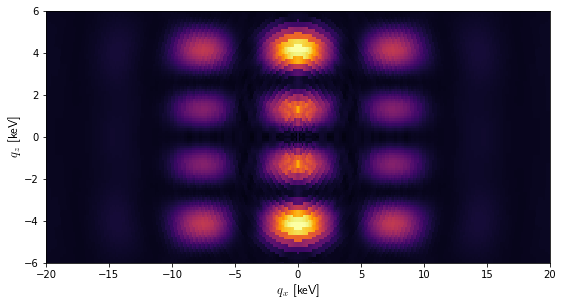

In [17]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-6, 6]
fig = plt.figure(figsize=[2.0*unisize,unisize])
axz = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz['all'], shading='nearest', cmap='inferno')
axz.set_xlim(xlim)
axz.set_ylim(ylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=13, usetex=True)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


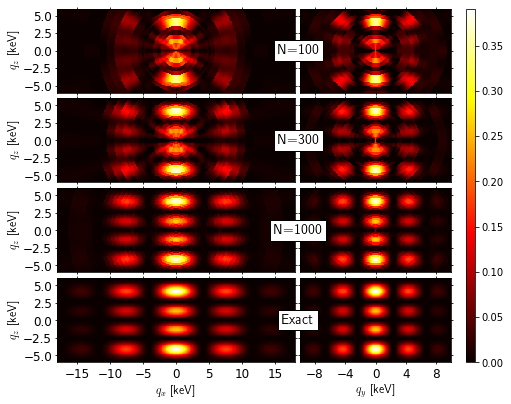

In [194]:
unisize = 3.5
xlim = [-18, 18]
ylim = [-10, 10]
zlim = [-6, 6]
x0 = 1.0
y0 = zlim[1]/xlim[1] * x0
x1 = ylim[1]/xlim[1] * x0 * 1.15
dy = 0.07
dx = 0.02
color = 'hot'
labels = 12
fonts = 14
# xtix = [-16, -12, -8, -4, 0, 4, 8, 12, 16]
xtix = [-15, -10, -5, 0, 5, 10, 15]
ytix = [-8, -4, 0, 4, 8]
ztix = [-5, -2.5, 0, 2.5, 5]

max_xy = np.max(fm4_xy_4['exact'])
max_xz = np.max(fm4_xz['exact'])
max_yz = np.max(fm4_yz['exact'])
max_z = np.max([max_xz, max_yz, max_xy])
# print(max_xy, max_xz, max_yz)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=color)
pcoloroptions = dict(shading='nearest', cmap=color, vmin=0, vmax=max_z)

fig = plt.figure(figsize=[1.15*x0*unisize,y0*unisize])
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV

ax_ext = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax_ext.pcolormesh(qXY_keV, qZ_keV, fm4_xz['exact'], **pcoloroptions)
ax_ext.set_xlim(xlim)
ax_ext.set_ylim(zlim)
ax_ext.set_xticks(xtix)
ax_ext.set_yticks(ztix)
ax_ext.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
ax_ext.set_ylabel(r'$q_z$ [keV]', fontsize=labels, usetex=True)
ax_ext.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=True, labeltop=False)

ay_ext = fig.add_axes([1+dx,0,x1,1], xscale='linear', yscale='linear')
ay_ext.pcolormesh(qXY_keV, qZ_keV, fm4_yz['exact'], **pcoloroptions)
ay_ext.set_xlim(ylim)
ay_ext.set_ylim(zlim)
ay_ext.set_xticks(ytix)
ay_ext.set_yticks(ztix)
ay_ext.set_xlabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ay_ext.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=False, labelright=False,
                   labelbottom=True, labeltop=False)
ay_ext.text(-0.5*dx, 0.5, ' '+r'Exact ', horizontalalignment='center',
            verticalalignment='center', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ay_ext.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))

# ax_all = fig.add_axes([0,1+dy,1,1], xscale='linear', yscale='linear')
# ax_all.pcolormesh(qXY_keV, qZ_keV, fm4_xz['all'], **pcoloroptions)
# ax_all.set_xlim(xlim)
# ax_all.set_ylim(zlim)
# ax_all.set_xticks(xtix)
# ax_all.set_yticks(ztix)
# # ax_all.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
# ax_all.set_ylabel(r'$q_z$ [keV]', fontsize=labels, usetex=True)
# ax_all.tick_params(axis='both', labelsize=labels, direction='inout',
#                    right=True, top=True, labelleft=True, labelright=False,
#                    labelbottom=False, labeltop=False)

# ay_all = fig.add_axes([1+dx,1+dy,x1,1], xscale='linear', yscale='linear')
# ay_all.pcolormesh(qXY_keV, qZ_keV, fm4_yz['all'], **pcoloroptions)
# ay_all.set_xlim(ylim)
# ay_all.set_ylim(zlim)
# ay_all.set_xticks(ytix)
# ay_all.set_yticks(ztix)
# # ay_all.set_xlabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
# ay_all.tick_params(axis='both', labelsize=labels, direction='inout',
#                    right=True, top=True, labelleft=False, labelright=False,
#                    labelbottom=False, labeltop=False)
# ay_all.text(-0.5*dx, 0.5, r'N={}'.format(len(nlm_ordered)), 
#             horizontalalignment='center',
#             verticalalignment='center', fontsize=fonts, 
#             color='black', backgroundcolor='white',
#             transform=ay_all.transAxes, usetex=True, 
#             bbox=dict(edgecolor='black', facecolor='white'))

ax_1000 = fig.add_axes([0,1+1*dy,1,1], xscale='linear', yscale='linear')
ax_1000.pcolormesh(qXY_keV, qZ_keV, fm4_xz[1000], **pcoloroptions)
ax_1000.set_xlim(xlim)
ax_1000.set_ylim(zlim)
ax_1000.set_xticks(xtix)
ax_1000.set_yticks(ztix)
ax_1000.set_ylabel(r'$q_z$ [keV]', fontsize=labels, usetex=True)
ax_1000.tick_params(axis='both', labelsize=labels, direction='inout',
                    right=True, top=True, labelleft=True, labelright=False,
                    labelbottom=False, labeltop=False)

ay_1000 = fig.add_axes([1+dx,1+1*dy,x1,1], xscale='linear', yscale='linear')
ay_1000.pcolormesh(qXY_keV, qZ_keV, fm4_yz[1000], **pcoloroptions)
ay_1000.set_xlim(ylim)
ay_1000.set_ylim(zlim)
ay_1000.set_xticks(ytix)
ay_1000.set_yticks(ztix)
ay_1000.tick_params(axis='both', labelsize=labels, direction='inout',
                    right=True, top=True, labelleft=False, labelright=False,
                    labelbottom=False, labeltop=False)
ay_1000.text(-0.5*dx, 0.5, r'N={}'.format(1000), 
             horizontalalignment='center',
             verticalalignment='center', fontsize=fonts, 
             color='black', backgroundcolor='white',
             transform=ay_1000.transAxes, usetex=True, 
             bbox=dict(edgecolor='black', facecolor='white'))

ax_300 = fig.add_axes([0,2+2*dy,1,1], xscale='linear', yscale='linear')
ax_300.pcolormesh(qXY_keV, qZ_keV, fm4_xz[300], **pcoloroptions)
ax_300.set_xlim(xlim)
ax_300.set_ylim(zlim)
ax_300.set_xticks(xtix)
ax_300.set_yticks(ztix)
ax_300.set_ylabel(r'$q_z$ [keV]', fontsize=labels, usetex=True)
ax_300.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=False, labeltop=False)

ay_300 = fig.add_axes([1+dx,2+2*dy,x1,1], xscale='linear', yscale='linear')
ay_300.pcolormesh(qXY_keV, qZ_keV, fm4_yz[300], **pcoloroptions)
ay_300.set_xlim(ylim)
ay_300.set_ylim(zlim)
ay_300.set_xticks(ytix)
ay_300.set_yticks(ztix)
ay_300.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=False, labelright=False,
                   labelbottom=False, labeltop=False)
ay_300.text(-0.5*dx, 0.5, r'N={}'.format(300), 
            horizontalalignment='center',
            verticalalignment='center', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ay_300.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))

ax_100 = fig.add_axes([0,3+3*dy,1,1], xscale='linear', yscale='linear')
ax_100.pcolormesh(qXY_keV, qZ_keV, fm4_xz[100], **pcoloroptions)
ax_100.set_xlim(xlim)
ax_100.set_ylim(zlim)
ax_100.set_xticks(xtix)
ax_100.set_yticks(ztix)
ax_100.set_ylabel(r'$q_z$ [keV]', fontsize=labels, usetex=True)
ax_100.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=False, labeltop=False)

ay_100 = fig.add_axes([1+dx,3+3*dy,x1,1], xscale='linear', yscale='linear')
ay_100.pcolormesh(qXY_keV, qZ_keV, fm4_yz[100], **pcoloroptions)
ay_100.set_xlim(ylim)
ay_100.set_ylim(zlim)
ay_100.set_xticks(ytix)
ay_100.set_yticks(ztix)
ay_100.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=False, labelright=False,
                   labelbottom=False, labeltop=False)
ay_100.text(-0.5*dx, 0.5, r'N={}'.format(100), 
            horizontalalignment='center',
            verticalalignment='center', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ay_100.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))

fig.colorbar(mappable=clmapZ, aspect=40, 
             orientation='vertical', location='right', 
             ax=[ax_ext, ay_ext, ax_1000, ay_1000, 
                 ax_300, ay_300, ax_100, ay_100],
             pad=0.03,
             )


fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


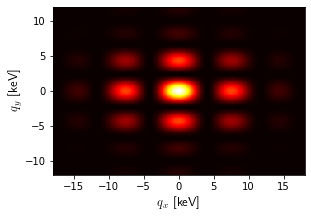

In [115]:
unisize = 3.5
xlim = [-18, 18]
ylim = [-12, 12]
fig = plt.figure(figsize=[unisize,ylim[1]/xlim[1]*unisize])
axy = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4['exact'], 
               shading='nearest', cmap='hot')
axy.set_xlim(xlim)
axy.set_ylim(ylim)
axy.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axy.set_ylabel(r'$q_y$ [keV]', fontsize=13, usetex=True)
# axy.set_aspect('equal')

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


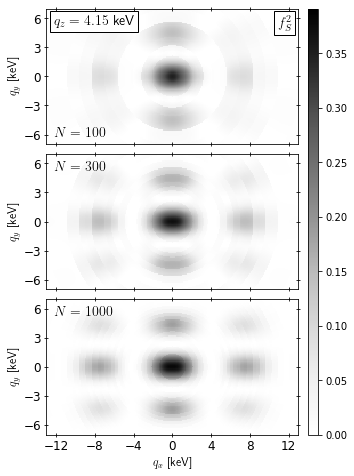

In [191]:
unisize = 3.5
xlim = [-13, 13]
ylim = [-7, 7]
fig = plt.figure(figsize=[1.22*unisize,ylim[1]/xlim[1]*unisize])
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV

dy = 0.07
dx = 0.035
color = 'Greys'
labels = 12
fonts = 14
xtix = [-12, -8, -4, 0, 4, 8, 12]
# xtix = [-15, -10, -5, 0, 5, 10, 15]
# ytix = [-8, -4, 0, 4, 8]
ytix = [-6, -3, 0, 3, 6]

max_xy = np.max(fm4_xy_4['exact'])
max_xz = np.max(fm4_xz['exact'])
max_yz = np.max(fm4_yz['exact'])
max_z = np.max([max_xz, max_yz, max_xy])
# print(max_xy, max_xz, max_yz)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=color)
pcoloroptions = dict(shading='nearest', cmap=color, vmin=0, vmax=max_z)


# ax_ext = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax_ext.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4['exact'], **pcoloroptions)
# ax_ext.set_xlim(xlim)
# ax_ext.set_ylim(ylim)
# ax_ext.set_xticks(xtix)
# ax_ext.set_yticks(ytix)
# ax_ext.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
# # ax_ext.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
# ax_ext.tick_params(axis='both', labelsize=labels, direction='inout',
#                    right=True, top=True, labelleft=False, labelright=False,
#                    labelbottom=True, labeltop=False)
# ax_ext.text(0.03, 0.95, r'Exact', horizontalalignment='left',
#             verticalalignment='top', fontsize=fonts, 
#             color='black', backgroundcolor='white',
#             transform=ax_ext.transAxes, usetex=True, 
#             bbox=dict(edgecolor='black', facecolor='white'))
# ax_ext.set_aspect('equal')

ax_1000 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax_1000 = fig.add_axes([-1-dx,0,1,1], xscale='linear', yscale='linear')
ax_1000.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[1000], **pcoloroptions)
ax_1000.set_xlim(xlim)
ax_1000.set_ylim(ylim)
ax_1000.set_xticks(xtix)
ax_1000.set_yticks(ytix)
ax_1000.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
ax_1000.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_1000.tick_params(axis='both', labelsize=labels, direction='inout',
                    right=True, top=True, labelleft=True, labelright=False,
                    labelbottom=True, labeltop=False)
ax_1000.text(0.03, 0.95, r'$N=1000$', horizontalalignment='left',
             verticalalignment='top', fontsize=fonts, 
             color='black', backgroundcolor='none',
             transform=ax_1000.transAxes, usetex=True)
ax_1000.set_aspect('equal')

ax_300 = fig.add_axes([0,1+1*dy,1,1], xscale='linear', yscale='linear')
ax_300.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[300], **pcoloroptions)
ax_300.set_xlim(xlim)
ax_300.set_ylim(ylim)
ax_300.set_xticks(xtix)
ax_300.set_yticks(ytix)
ax_300.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_300.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=False, labeltop=False)
ax_300.text(0.03, 0.95, r'$N=300$', horizontalalignment='left',
            verticalalignment='top', fontsize=fonts, 
            color='black', backgroundcolor='none',
            transform=ax_300.transAxes, usetex=True)
ax_300.set_aspect('equal')

ax_100 = fig.add_axes([0,2+2*dy,1,1], xscale='linear', yscale='linear')
ax_100.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[100], **pcoloroptions)
ax_100.set_xlim(xlim)
ax_100.set_ylim(ylim)
ax_100.set_xticks(xtix)
ax_100.set_yticks(ytix)
ax_100.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_100.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=False, labeltop=False)
ax_100.text(0.03, 0.04, r'$N=100$', horizontalalignment='left',
            verticalalignment='bottom', fontsize=fonts, 
            color='black', backgroundcolor='none',
            transform=ax_100.transAxes, usetex=True)
ax_100.text(0.97, 0.95, r'$f_S^2$', horizontalalignment='right',
            verticalalignment='top', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ax_100.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_100.text(0.03, 0.95, r'$q_z=4.15$ keV', horizontalalignment='left',
            verticalalignment='top', fontsize=fonts, 
            color='black', backgroundcolor='none',
            transform=ax_100.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_100.set_aspect('equal')

fig.colorbar(mappable=clmapZ, aspect=40, 
             orientation='vertical', location='right', 
             ax=[ax_1000, ax_300, ax_100],
             pad=0.03,
             )


fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


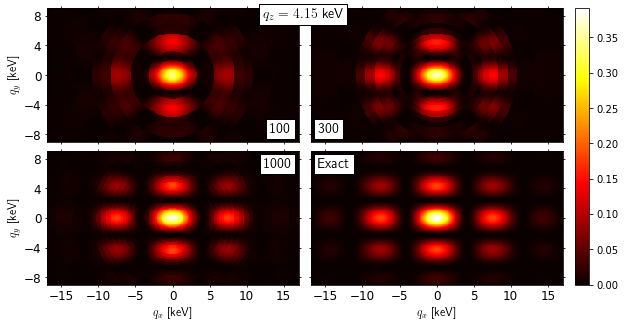

In [160]:
unisize = 3.5
xlim = [-17, 17]
ylim = [-9, 9]
fig = plt.figure(figsize=[1.22*unisize,ylim[1]/xlim[1]*unisize])
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV

dy = 0.07
dx = 0.035
color = 'hot'
labels = 12
fonts = 14
# xtix = [-16, -12, -8, -4, 0, 4, 8, 12, 16]
xtix = [-15, -10, -5, 0, 5, 10, 15]
ytix = [-8, -4, 0, 4, 8]

max_xy = np.max(fm4_xy_4['exact'])
max_xz = np.max(fm4_xz['exact'])
max_yz = np.max(fm4_yz['exact'])
max_z = np.max([max_xz, max_yz, max_xy])
# print(max_xy, max_xz, max_yz)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=color)
pcoloroptions = dict(shading='nearest', cmap=color, vmin=0, vmax=max_z)


ax_ext = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax_ext.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4['exact'], **pcoloroptions)
ax_ext.set_xlim(xlim)
ax_ext.set_ylim(ylim)
ax_ext.set_xticks(xtix)
ax_ext.set_yticks(ytix)
ax_ext.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
# ax_ext.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_ext.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=False, labelright=False,
                   labelbottom=True, labeltop=False)
ax_ext.text(0.03, 0.95, r'Exact', horizontalalignment='left',
            verticalalignment='top', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ax_ext.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_ext.set_aspect('equal')

# ax_1000 = fig.add_axes([0,1+dy,1,1], xscale='linear', yscale='linear')
ax_1000 = fig.add_axes([-1-dx,0,1,1], xscale='linear', yscale='linear')
ax_1000.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[1000], **pcoloroptions)
ax_1000.set_xlim(xlim)
ax_1000.set_ylim(ylim)
ax_1000.set_xticks(xtix)
ax_1000.set_yticks(ytix)
ax_1000.set_xlabel(r'$q_x$ [keV]', fontsize=labels, usetex=True)
ax_1000.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_1000.tick_params(axis='both', labelsize=labels, direction='inout',
                    right=True, top=True, labelleft=True, labelright=False,
                    labelbottom=True, labeltop=False)
ax_1000.text(0.97, 0.95, r'1000', horizontalalignment='right',
             verticalalignment='top', fontsize=fonts, 
             color='black', backgroundcolor='white',
             transform=ax_1000.transAxes, usetex=True, 
             bbox=dict(edgecolor='black', facecolor='white'))
ax_1000.set_aspect('equal')

ax_300 = fig.add_axes([0,1+1*dy,1,1], xscale='linear', yscale='linear')
ax_300.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[300], **pcoloroptions)
ax_300.set_xlim(xlim)
ax_300.set_ylim(ylim)
ax_300.set_xticks(xtix)
ax_300.set_yticks(ytix)
# ax_300.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_300.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=False, labelright=False,
                   labelbottom=False, labeltop=False)
ax_300.text(0.03, 0.05, r'300', horizontalalignment='left',
            verticalalignment='bottom', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ax_300.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_300.set_aspect('equal')

ax_100 = fig.add_axes([-1-dx,1+1*dy,1,1], xscale='linear', yscale='linear')
ax_100.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4[100], **pcoloroptions)
ax_100.set_xlim(xlim)
ax_100.set_ylim(ylim)
ax_100.set_xticks(xtix)
ax_100.set_yticks(ytix)
ax_100.set_ylabel(r'$q_y$ [keV]', fontsize=labels, usetex=True)
ax_100.tick_params(axis='both', labelsize=labels, direction='inout',
                   right=True, top=True, labelleft=True, labelright=False,
                   labelbottom=False, labeltop=False)
ax_100.text(0.97, 0.05, r'100', horizontalalignment='right',
            verticalalignment='bottom', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ax_100.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_100.text(1+0.5*dx, 1.0, r'$q_z = 4.15$ keV', horizontalalignment='center',
            verticalalignment='top', fontsize=fonts, 
            color='black', backgroundcolor='white',
            transform=ax_100.transAxes, usetex=True, 
            bbox=dict(edgecolor='black', facecolor='white'))
ax_100.set_aspect('equal')

fig.colorbar(mappable=clmapZ, aspect=20, 
             orientation='vertical', location='right', 
             ax=[ax_ext, ax_1000, ax_300, ax_100],
             pad=0.02,
             )


fig.show()

## Ray plots

In [100]:
qmax = 10*qBohr
dq = 0.01*qBohr
qs = np.array([i*dq for i in range(int(qmax/dq)+1)]) # |q| list 
q_keV = np.array([q/keV for q in qs])

qzs = np.array([(qz, 0, 0) for qz in qs])
fz1 = np.array([fs2_m1(q) for q in qzs])
fz2 = np.array([fs2_m2(q) for q in qzs])
fz3 = np.array([fs2_m3(q) for q in qzs])

qxs = np.array([(qx, 0.5*np.pi, 0) for qx in qs])
fx1 = np.array([fs2_m1(q) for q in qxs])
fx2 = np.array([fs2_m2(q) for q in qxs])
fx3 = np.array([fs2_m3(q) for q in qxs])

qys = np.array([(qy, 0.5*np.pi, 0.5*np.pi) for qy in qs])
fy1 = np.array([fs2_m1(q) for q in qys])
fy2 = np.array([fs2_m2(q) for q in qys])
fy3 = np.array([fs2_m3(q) for q in qys])



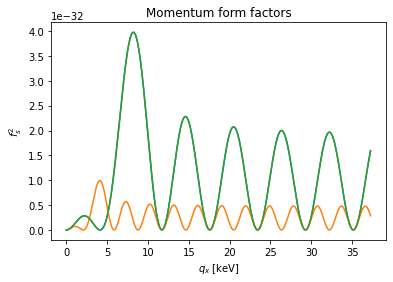

In [101]:
plt.plot(q_keV, fx1, q_keV, fx2, q_keV, fx3)
plt.xlabel(r'$q_x$ [keV]')
plt.ylabel(r'$f_s^2$')
plt.title('Momentum form factors')
plt.show()

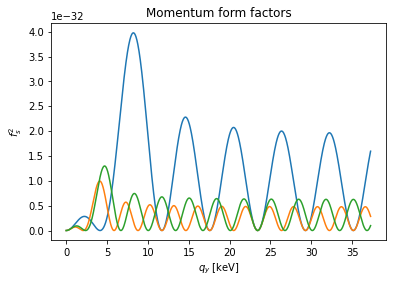

In [102]:
plt.plot(q_keV, fy1, q_keV, fy2, q_keV, fy3)
plt.xlabel(r'$q_y$ [keV]')
plt.ylabel(r'$f_s^2$')
plt.title('Momentum form factors')
plt.show()

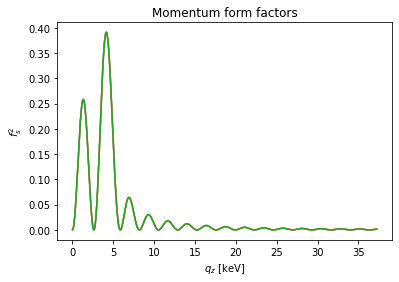

In [103]:
plt.plot(q_keV, fz1, q_keV, fz2, q_keV, fz3)
plt.xlabel(r'$q_z$ [keV]')
plt.ylabel(r'$f_s^2$')
plt.title('Momentum form factors')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


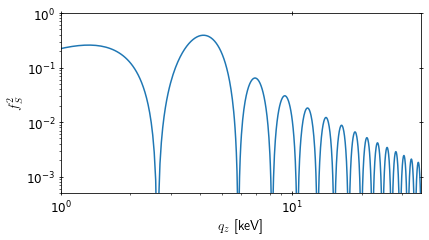

In [155]:
fig = plt.figure(figsize=[2*unisize,unisize])
ax4 = fig.add_axes([0,0,1,1], 
                   xscale='log', yscale='log')
ax4.plot(q_keV, fz3)
ax4.set_xlim([1, 36])
ax4.set_ylim([5e-4, 1])
ax4.set_xlabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ax4.set_ylabel(r'$f_S^2$', fontsize=fonts, usetex=True)
ax4.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)

fig.show()

## Heat Plots

In [105]:
qmaxXY = 6*qBohr
qmaxZ = 2.5*qBohr
dq = 0.01*qBohr
qpmXY = np.array([i*dq for i in range(-int(qmaxXY/dq), int(qmaxXY/dq)+1)]) # q list 
qpmZ = np.array([i*dq for i in range(-int(qmaxZ/dq), int(qmaxZ/dq)+1)]) # q list 

qXZlist = np.array([[(qx, 0, -qz) for qx in qpmXY] for qz in qpmZ])
qYZlist = np.array([[(0, qy, -qz) for qy in qpmXY] for qz in qpmZ])
qXYlist = np.array([[(qx, -qy, 0) for qx in qpmXY] for qy in qpmXY])
qXYlist_4 = np.array([[(qx, -qy, 4.15*keV) for qx in qpmXY] for qy in qpmXY])




In [25]:
Nx = len(qpmXY)
Ny = len(qpmXY)
Nz = len(qpmZ)

fm4_xz = np.array([[fs2_model4_cart(qXZlist[iz,ix]) 
                    for ix in range(Nx)] for iz in range(Nz)])


In [26]:
fm4_yz = np.array([[fs2_model4_cart(qYZlist[iz,iy]) 
                    for iy in range(Ny)] for iz in range(Nz)])


In [27]:
fm4_xy = np.array([[fs2_model4_cart(qXYlist[iy,ix]) 
                    for ix in range(Nx)] for iy in range(Ny)])


In [106]:
fm4_xy_4 = np.array([[fs2_model4_cart(qXYlist_4[iy,ix]) 
                    for ix in range(Nx)] for iy in range(Ny)])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


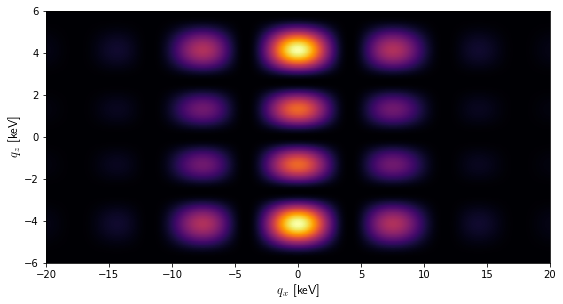

In [28]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-6, 6]
fig = plt.figure(figsize=[2.0*unisize,unisize])
axz = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz, shading='nearest', cmap='inferno')
axz.set_xlim(xlim)
axz.set_ylim(ylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=13, usetex=True)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


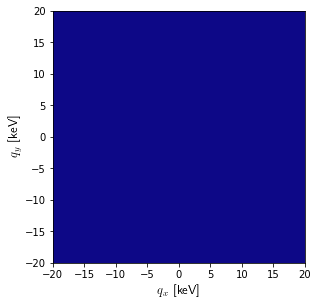

In [29]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-20, 20]
fig = plt.figure(figsize=[unisize,unisize])
axy = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy, shading='nearest', cmap='plasma')
axy.set_xlim(xlim)
axy.set_ylim(ylim)
axy.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axy.set_ylabel(r'$q_y$ [keV]', fontsize=13, usetex=True)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


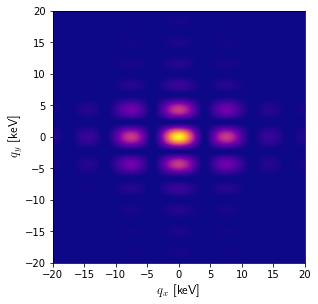

In [107]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-20, 20]
fig = plt.figure(figsize=[unisize,unisize])
axy = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4, 
               shading='nearest', cmap='plasma')
axy.set_xlim(xlim)
axy.set_ylim(ylim)
axy.set_xlabel(r'$q_x$ [keV]', fontsize=13, usetex=True)
axy.set_ylabel(r'$q_y$ [keV]', fontsize=13, usetex=True)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


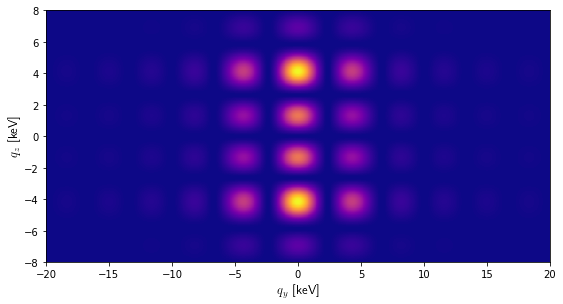

In [30]:
unisize = 3.5
xlim = [-20, 20]
ylim = [-8, 8]
fig = plt.figure(figsize=[2.0*unisize,unisize])
ayz = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
ayz.pcolormesh(qXY_keV, qZ_keV, fm4_yz, shading='nearest', cmap='plasma')
ayz.set_xlim(xlim)
ayz.set_ylim(ylim)
ayz.set_xlabel(r'$q_y$ [keV]', fontsize=13, usetex=True)
ayz.set_ylabel(r'$q_z$ [keV]', fontsize=13, usetex=True)

fig.show()

In [110]:
# max_xy = np.max(fm4_xy)
max_xy = np.max(fm4_xy_4)
max_xz = np.max(fm4_xz)
max_yz = np.max(fm4_yz)
max_z = np.max([max_xz, max_yz, max_xy])
print(max_xy, max_xz, max_yz)

0.3909322469504252 0.390992642345414 0.390992642345414


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


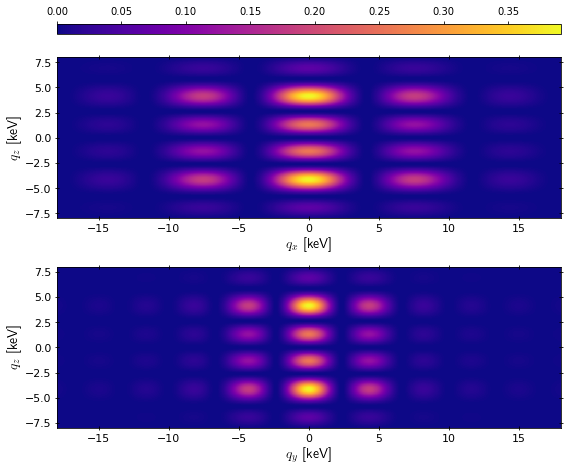

In [127]:
unisize = 2.8
fig = plt.figure(figsize=[20/8*unisize,1*unisize])
x0 = 0.0
dx0 = 0.0
y0 = 0.0
x2 = 1.75
fonts = 14
labels = 11
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV

zylim = [-8,8]
xylim = [-18, 18]

ayz = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ayz.pcolormesh(qXY_keV, qZ_keV, fm4_yz, shading='nearest', cmap='plasma')
ayz.set_xlim(xylim)
ayz.set_ylim(zylim)
ayz.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
ayz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ayz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)

axz = fig.add_axes([0,1.3,1,1], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz, shading='nearest', cmap='plasma')
axz.set_xlim(xylim)
axz.set_ylim(zylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
axz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap='plasma')

fig.colorbar(mappable=clmapZ,  
             orientation='horizontal', location='top', 
             aspect=50, ax=[ayz,axz],
             )

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


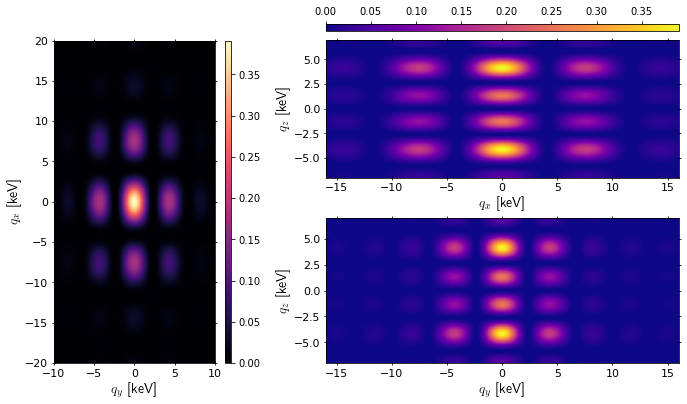

In [111]:
unisize = 2.8
fig = plt.figure(figsize=[unisize,unisize])
x0 = 1.0
dx0 = 0.35
y0 = 1.6
x2 = 1.75
fonts = 14
labels = 11
axy = fig.add_axes([0,0,x0,y0], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4.transpose(), shading='nearest', cmap='magma')
axy.set_ylim([-20, 20])
axy.set_xlim( [-10, 10])
axy.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
axy.set_ylabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axy.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)

cnormXY = plt.Normalize(vmin=0, vmax=max_z)
clmapXY = plt.cm.ScalarMappable(norm=cnormXY, cmap='magma')

fig.colorbar(mappable=clmapXY, 
             orientation='vertical', location='right', 
             aspect=50)

zylim = [-7,7]

ayz = fig.add_axes([x0+dx0,0,x2,0.45*y0], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
ayz.pcolormesh(qXY_keV, qZ_keV, fm4_yz, shading='nearest', cmap='plasma')
ayz.set_xlim([-16, 16])
ayz.set_ylim(zylim)
ayz.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
ayz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ayz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)

axz = fig.add_axes([x0+dx0,0.575*y0,x2,0.535*y0], xscale='linear', yscale='linear')
qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz, shading='nearest', cmap='plasma')
axz.set_xlim([-16, 16])
axz.set_ylim(zylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
axz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap='plasma')

fig.colorbar(mappable=clmapZ,  
             orientation='horizontal', location='top', 
             aspect=50)

fig.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


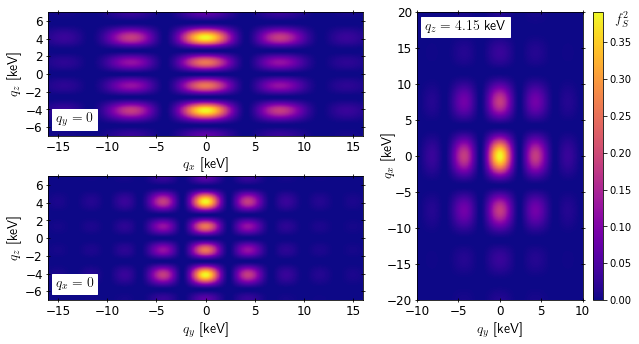

In [151]:
unisize = 2.5
fig = plt.figure(figsize=[unisize,unisize])
x0 = 1.0
dx0 = 0.3
dy0 = 0.07
y0 = 1.6
x2 = 1.75
fonts = 14
labels = 12
colorXY = 'plasma'
colorZ = 'plasma'

qXY_keV = qpmXY/keV
qZ_keV = qpmZ/keV
zylim = [-7,7]
ztix = [-6, -4, -2, 0, 2, 4, 6]

ayz = fig.add_axes([0,0,x2,(0.5 - dy0)*y0], xscale='linear', yscale='linear')
ayz.pcolormesh(qXY_keV, qZ_keV, fm4_yz, shading='nearest', cmap=colorZ)
ayz.set_xlim([-16, 16])
ayz.set_ylim(zylim)
ayz.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
ayz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
ayz.set_yticks(ztix)
ayz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ayz.text(0.025, 0.08, r'$q_x=0$', horizontalalignment='left',
         verticalalignment='bottom', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ayz.transAxes, usetex=True)

axz = fig.add_axes([0,(0.5+dy0)*y0,x2,(0.5 - dy0)*y0], xscale='linear', yscale='linear')
axz.pcolormesh(qXY_keV, qZ_keV, fm4_xz, shading='nearest', cmap=colorZ)
axz.set_xlim([-16, 16])
axz.set_ylim(zylim)
axz.set_xlabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axz.set_ylabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
axz.set_yticks(ztix)
axz.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
axz.text(0.025, 0.08, r'$q_y=0$', horizontalalignment='left',
         verticalalignment='bottom', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axz.transAxes, usetex=True)

cnormZ = plt.Normalize(vmin=0, vmax=max_z)
clmapZ = plt.cm.ScalarMappable(norm=cnormZ, cmap=colorZ)


axy = fig.add_axes([x2+dx0,0,1.15*x0,y0], 
                   xscale='linear', yscale='linear')
axy.pcolormesh(qXY_keV, qXY_keV, fm4_xy_4.transpose(), shading='nearest', cmap=colorXY)
axy.set_ylim([-20, 20])
axy.set_xlim( [-10, 10])
axy.set_xlabel(r'$q_y$ [keV]', fontsize=fonts, usetex=True)
axy.set_ylabel(r'$q_x$ [keV]', fontsize=fonts, usetex=True)
axy.yaxis.set_label_position('left')
axy.yaxis.set_label_coords(-0.13,0.5)
axy.set_xticks([-10, -5, 0, 5, 10])
axy.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True)
axy.text(0.05, 0.97, r'$q_z=4.15$ keV', horizontalalignment='left',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axy.transAxes, usetex=True)
axy.text(1.235, 1.00, r'$f_S^2$', horizontalalignment='center',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=axy.transAxes, usetex=True)

cnormXY = plt.Normalize(vmin=0, vmax=max_z)
clmapXY = plt.cm.ScalarMappable(norm=cnormXY, cmap=colorXY)

fig.colorbar(mappable=clmapXY, 
             orientation='vertical', location='right', 
             aspect=30)

# fig.colorbar(mappable=clmapZ,  
#              orientation='horizontal', location='top', 
#              aspect=50)


# ax4 = fig.add_axes([0,y0+3.5*dy0,x2+dx0+1.1*x0,0.4*y0], 
#                    xscale='linear', yscale='log')
# ax4.plot(q_keV, fz3)
# ax4.set_xlim([0, 30])
# ax4.set_ylim([5e-4, 1])
# ax4.set_xlabel(r'$q_z$ [keV]', fontsize=fonts, usetex=True)
# ax4.set_ylabel(r'$f_S^2$', fontsize=fonts, usetex=True)
# ax4.tick_params(axis='both', labelsize=labels, direction='inout',
#                 right=True, top=True)

fig.show()